In [1]:
import function_book as f
import pandas as pd
import numpy as np
import baostock as bs

In [8]:
step1_file= "tmt_stock_basic.csv" 
step2_file = "TMT_stock_price.csv"
step3_file = "TMT_stock_details.csv"

class my_fama_french:
    
    def __init__(self,start_date_str = "2018-04-02",end_date_str = "2020-04-30",
                 back_test_year = 2,stockspool_details_file = step3_file,
                 stockspool_price_file = None,stockspool_basic_file=None):
        
        # start date of backing test start_date_str 
        # end date of backing test end_date_str
        self.back_test_year = back_test_year 
        
        self.trading_date = 245
        self.short = False 
        self.prof_size = None
        #self.freq = False
        
        self.s_selected_list = None
        self.s_profolio = None
        
        self.profolio = []
        self.selected_list = [] 
        self.stock_results_df = None
        
        # generate self.stock_details_df
        if stockspool_details_file is not None: # including factor we need 
            self.stock_details_df = pd.read_csv(stockspool_details_file, encoding='utf_8')
        else:
            ave_step = 5 # average days of close.average pbMRQ. f.generate_stock_price
            quarter_date_list = f.get_quarter_date_list(start_date_str,end_date_str)
            if stockspool_price_file is not None:
                stock_price_df = pd.read_csv(stockspool_price_file, encoding='utf_8')
                self.stock_details_df = f.generate_stock_details(stock_price_df,quarter_date_list)
            else:
                if stockspool_basic_file is not None:
                    stock_basic_df = pd.read_csv(stockspool_basic_file, encoding='utf_8')  #my stocks pool, which including code and codename
                    stock_price_df = f.generate_stock_price(stock_basic_df,start_date_str,end_date_str,ave_step,columns_str = "date,code,close,pbMRQ,isST")
                    self.stock_details_df = f.generate_stock_details(stock_price_df,quarter_date_list)
                else:
                    print("failed initilization, pls give stockspool")
                    
    def get_famafrench_stocks(self,prof_size:int,freq=False,short=False):
        self.prof_size = prof_size #number of stocks select from the strategy
        #self.freq = freq # false means, only rebalance weight when stocks changes
        self.short = short
        (self.select_list,self.s_select_list) = f.get_famafrench_stocks(self.stock_details_df,self.prof_size,freq,self.short)
        
    def get_profolio_performance(self,chunk_size:int,profolio = None):
        
        if profolio is None:
            profolio = f.all_rebalance_weights(self.select_list,[],chunk_size)
            
        result = f.profolio_ana(profolio,self.prof_size)
        result['sum'] = result.sum(axis = 1)
        backtest_enddate = result.index[245*self.back_test_year]
        backtest_result = result.loc[:backtest_enddate]
        profit =backtest_result.iloc[-1]['sum']/ backtest_result.iloc[0]['sum']
        Annual_return_rate  = (profit ** (1/self.back_test_year) -1 ) *100
        delta = f.max_withdrawal_rate(backtest_result['sum'])
       
        print("profolio size:",self.prof_size," profolio weights: simulate",chunk_size,"year. annual return",Annual_return_rate, "  max withdraw:",delta)
        #return profit,Annual_return_rate, delta
        return backtest_result
    

In [10]:
obj3 = my_fama_french()
obj3.get_famafrench_stocks(prof_size = 3)# profolio with 3 stocks
profolio_3 = obj3.get_profolio_performance(chunk_size = 3)

login success!
logout success!
profolio size: 3  profolio weights: simulate 3 year. annual return 34.17745996958119   max withdraw: 28.24730635456359


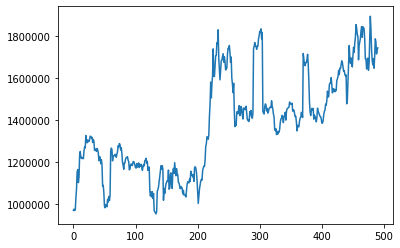

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,len(profolio_3),1),profolio_3['sum'])